<a href="https://colab.research.google.com/github/novtryrezki/Terbaru/blob/main/2CNN_bs_64_ep_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import random
import shutil
import numpy as np
import tensorflow as tf
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split

In [2]:
# Melakukan mount pada Google Drive
drive.mount('/content/drive')

# Menentukan path file ZIP di Google Drive
zip_path = '/content/drive/MyDrive/images.zip'

# Membuat objek zip_ref
zip_ref = zipfile.ZipFile(zip_path, 'r')

# Mengekstrak file ZIP
extract_path ='/content/images'
zip_ref.extractall(extract_path)

# Tutup objek zip_ref setelah selesai
zip_ref.close()

Mounted at /content/drive


In [3]:
# Mendefinisikan path direktori dataset
dataset_dir = os.path.join(extract_path, 'images')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
list_train = sorted(os.listdir(train_dir))
list_test = sorted(os.listdir(test_dir))

print("Daftar Angka pada Dataset Train yaitu : ", list_train)
print("Daftar Angka pada Dataset Test yaitu : ", list_test)

Daftar Angka pada Dataset Train yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']
Daftar Angka pada Dataset Test yaitu :  ['angka 0', 'angka 1', 'angka 2', 'angka 3', 'angka 4', 'angka 5', 'angka 6', 'angka 7', 'angka 8', 'angka 9']


In [4]:
def count_images(directory):
    return sum(1 for file in os.listdir(directory) if file.endswith(('.jpg', '.jpeg', '.png', '.gif')))

# Menghitung jumlah gambar di data train
train_image_count = sum(count_images(os.path.join(train_dir, angka)) for angka in list_train)

# Menghitung jumlah gambar di data test
test_image_count = sum(count_images(os.path.join(test_dir, angka)) for angka in list_test)

print(f"Jumlah gambar di Dataset Train: {train_image_count}")
print(f"Jumlah gambar di Dataset Test: {test_image_count}")

Jumlah gambar di Dataset Train: 1763
Jumlah gambar di Dataset Test: 445


# Preprocessing

In [5]:
import cv2

def resize_images(directory, target_resolution):
    for angka in os.listdir(directory):
        angka_dir = os.path.join(directory, angka)
        for file_name in os.listdir(angka_dir):
            file_path = os.path.join(angka_dir, file_name)
            img = cv2.imread(file_path)
            resized_img = cv2.resize(img, (target_resolution[0], target_resolution[1]))
            cv2.imwrite(file_path, resized_img)

target_resolution = (52, 78)
resize_images(train_dir, target_resolution)
resize_images(test_dir, target_resolution)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Membuat generator data dengan augmentasi
image_size = (52, 78)
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 1763 images belonging to 10 classes.
Found 445 images belonging to 10 classes.


# Membuat Model CNN

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense
import math

img_size = 52*78*1

# Perhitungan jumlah neuron pada lapisan tersembunyi
r1 = (img_size/10) ** (1/2)
r2 = (img_size/10)**(1/3)

hidden_neurons1 = 10 * r1**(2)
hidden_neurons2 = 10 * r2**(1)

model2c = Sequential()
model2c.add(Conv2D(32, (3, 3), input_shape=(52, 78, 1)))
model2c.add(AveragePooling2D((2, 2)))
model2c.add(Conv2D(64, (3, 3)))
model2c.add(AveragePooling2D((2, 2)))
model2c.add(Flatten())
model2c.add(Dense(hidden_neurons1, activation='relu'))
model2c.add(Dense(hidden_neurons2, activation='relu'))
model2c.add(Dense(10, activation='softmax'))

model2c.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model2c.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 76, 32)        320       
                                                                 
 average_pooling2d (Average  (None, 25, 38, 32)        0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 36, 64)        18496     
                                                                 
 average_pooling2d_1 (Avera  (None, 11, 18, 64)        0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                                 
 dense (Dense)               (None, 4055)              5

In [9]:
history = model2c.fit(train_generator, epochs=20, verbose = 1)

Epoch 1/20
28/28 [==============================] - 34s 1s/step - loss: 2.0727 - accuracy: 0.3091
Epoch 2/20
28/28 [==============================] - 33s 1s/step - loss: 1.9573 - accuracy: 0.3630
Epoch 3/20
28/28 [==============================] - 35s 1s/step - loss: 1.9144 - accuracy: 0.3687
Epoch 4/20
28/28 [==============================] - 34s 1s/step - loss: 1.8739 - accuracy: 0.3772
Epoch 5/20
28/28 [==============================] - 33s 1s/step - loss: 1.8569 - accuracy: 0.3840
Epoch 6/20
28/28 [==============================] - 33s 1s/step - loss: 1.7997 - accuracy: 0.4005
Epoch 7/20
28/28 [==============================] - 32s 1s/step - loss: 1.8311 - accuracy: 0.3772
Epoch 8/20
28/28 [==============================] - 33s 1s/step - loss: 1.7884 - accuracy: 0.4027
Epoch 9/20
28/28 [==============================] - 32s 1s/step - loss: 1.7823 - accuracy: 0.4073
Epoch 10/20
28/28 [==============================] - 33s 1s/step - loss: 1.7597 - accuracy: 0.4061
Epoch 11/20
28/28 [

#Matriks Konfusi

7/7 [==============================] - 2s 279ms/step


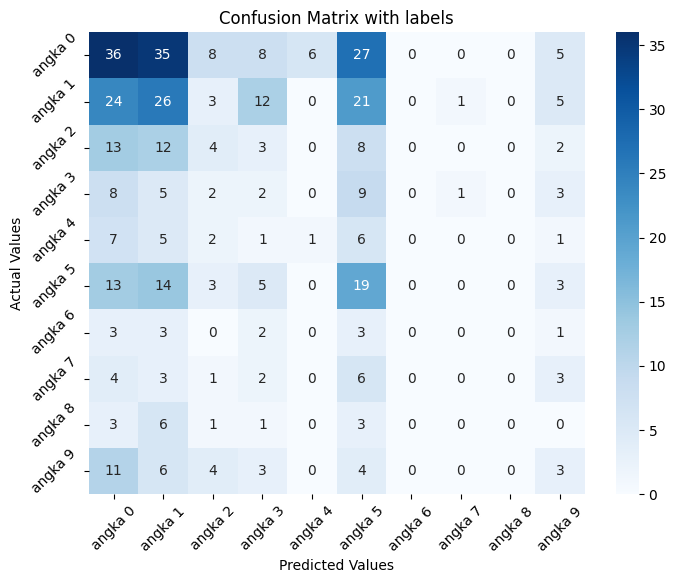

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Fungsi untuk mendapatkan prediksi model dan label sebenarnya
def get_predictions_and_labels(model, data_generator):
    predictions = model.predict(data_generator)
    true_classes = data_generator.classes
    return predictions, true_classes

# Mendapatkan prediksi dan label sebenarnya untuk data uji
y_pred_prob, y_true = get_predictions_and_labels(model2c, test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

# Membuat matriks konfusi
cf_matrix = confusion_matrix(y_true, y_pred)

# Membuat visualisasi matriks konfusi
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', ax=ax)

# Menetapkan label dan judul
ax.set_title('Confusion Matrix with labels')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')

class_labels = list(test_generator.class_indices.keys())

# Menetapkan label pada sumbu x dan y sesuai dengan jenis kelas
ax.xaxis.set_ticklabels(class_labels, rotation=45)
ax.yaxis.set_ticklabels(class_labels, rotation=45)

# Menampilkan visualisasi Matriks Konfusi
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")

Test Accuracy: 0.20449438202247192
